<a href="https://colab.research.google.com/github/jinburge/Congressional-Analytics/blob/main/CP_Rec_Center_Weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Does Weather Influence the Congestion at the Cal Poly Rec Center?***

#### By Jin Burge (jbburge@calpoly.edu) and Athena Kwok (akwok01@calpoly.edu)

#### Feburary 28, 2022

## **Introduction**

The Cal Poly Rec Center is one of the main attractions of the beautiful campus and a popular destination for students. One of the only complaints heard regarding the facility is the over-crowdedness, possibly deterring students from entering. 

The weather in San Luis Obispo is known to be sunny and warm in the spring and summer, and cold and cloudy during the winter. This year, more extreme weather occurred from reaching a scorching 104 degrees Fahrenheit in early September to a brutal storm in early January. 


For our final project, we are interested in how weather influences the congestion at the Cal Poly Rec Center. After contacting Cal Poly ASI, we were provided with gate entry statistics at the recreation center. Although we desired to obtain multiple years of data to analyze these trends, Covid restrictions from the year prior would not give us an accurate depiction of entry patterns. Therefore, we were limited with the amount of data given and are using gate entry statistics from *September 12, 2022 to February 20, 2023*. 


Given the data provided, we speculate that students would be more motivated to use the recreation center when the weather is colder. When the weather is warmer, we imagine that there are more alternative activities that students would partake in, such as going to the beach, hiking on trails, or playing outdoor sports. Contrastingly, when the temperature is lower (or possibly even raining), students will feel confined indoors and will not have as many options for activities. 


Thus, our hypothesis is that, *in general, a decrease in temperature is correlated with an increase in the amount of people who use the Cal Poly Rec Center*. 



## **Scrape Weather Data**

In [ ]:
# Reading in Libraries
import pandas as pd 
from pandas.tseries.offsets import BDay
import json 
from urllib.request import urlopen 
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install meteostat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import Meteostat library and dependencies
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily

# Set time period
start = datetime(2022, 9, 12)
end = datetime(2023, 2, 20)

# Create Point for San Luis Obispo
location = Point(35.2827524, -120.680656, 70)

# Get daily data for 9/12/22 to 2/20/23
data = Daily(location, start, end)
data = data.fetch()

# Extract only average temperature 
cols = ["time", "tavg"]
weather_df = pd.DataFrame(data, columns = cols)

# Convert degrees Celsius to Fahrenheit
weather_df["Average Temperature (F)"] = 1.8*weather_df["tavg"] + 32

In [ ]:
from google.colab import drive
drive.mount('drive')

weather_df.to_csv('df.csv')
!cp df.csv "drive/My Drive/"

Mounted at drive


In [ ]:
url = 'https://raw.githubusercontent.com/jinburge/FinalProject/main/weather_df2.csv'
weather_df2 = pd.read_csv(url)

weather_df2["Average Temperature (F)"] = weather_df2["tF"]
weather_df2 = weather_df2.drop(columns = ["tF"])

weather_df2.head()


,time,tavg,Average Temperature (F)
0,9/12/22,20.8,69.44
1,9/13/22,19.0,66.20
2,9/14/22,18.4,65.12
3,9/15/22,18.1,64.58
4,9/16/22,18.0,64.40


## **Import Cal Poly Rec Data**

In [ ]:
url = 'https://raw.githubusercontent.com/jinburge/FinalProject/main/rec_daily.csv'
cp_df = pd.read_csv(url)

# Select columns
cp_df = pd.DataFrame(cp_df)

cp_df.head()

,Date,Entrances
0,9/12/22,2066
1,9/13/22,2410
2,9/14/22,3047
3,9/15/22,2656
4,9/16/22,3217


### **Merge Datasets**

In [ ]:
merged_df = pd.merge(weather_df2, cp_df, left_on='time', right_on='Date')

**Dataset for All the Data**

In [ ]:
## Cleaning Merged Dataset
# Drop columns
merged_df = merged_df.drop(columns = ["time", "tavg"])

# Change column order
merged_df = merged_df[["Date", "Average Temperature (F)", "Entrances"]]

# Final Dataset with Outliers
merged_df.head()

,Date,Average Temperature (F),Entrances
0,9/12/22,69.44,2066
1,9/13/22,66.20,2410
2,9/14/22,65.12,3047
3,9/15/22,64.58,2656
4,9/16/22,64.40,3217


**Dataset Accounting for Holidays**

In [ ]:
# Remove Outliers (Holidays, Breaks)
merged_df2 = merged_df

# Thanksgiving 11/21-11/27
merged_df2 = merged_df.drop(merged_df.index[70:76])

# Winter 12/10-1/8
merged_df2 = merged_df.drop(merged_df.index[89:118])

# Drop values when rec was closed
merged_df2 = merged_df2.drop(merged_df2[merged_df2.Entrances == 0].index)

# Final Dataset Without Outliers
merged_df2


,Date,Average Temperature (F),Entrances
0,9/12/22,69.44,2066
1,9/13/22,66.20,2410
2,9/14/22,65.12,3047
3,9/15/22,64.58,2656
4,9/16/22,64.40,3217
...,...,...,...
157,2/16/23,45.14,4630
158,2/17/23,48.02,3350
159,2/18/23,51.98,2035
160,2/19/23,53.60,2158


**Dataset without Holidays and Weekends**

In [ ]:
# Removing Weekends
isBusinessDay = BDay().onOffset
match_series = pd.to_datetime(merged_df2['Date']).map(isBusinessDay)
merged_df3 = merged_df2[match_series]

merged_df3

,Date,Average Temperature (F),Entrances
0,9/12/22,69.44,2066
1,9/13/22,66.20,2410
2,9/14/22,65.12,3047
3,9/15/22,64.58,2656
4,9/16/22,64.40,3217
...,...,...,...
155,2/14/23,50.00,5152
156,2/15/23,47.12,5007
157,2/16/23,45.14,4630
158,2/17/23,48.02,3350


For our analysis, we created three final datasets. The first dataset includes all the data, 163 days worth of observations. The second dataset, 131 days of observations, removes the holidays and breaks (Thanksgiving and Winter break), in addition to the days that the recreation center was closed. The third dataset, 94 days of observations, also removes weekends (in addition to the breaks and closed days that were removed in the second dataset). 

## **Visualizations**

Text(0, 0.5, 'Entrances')

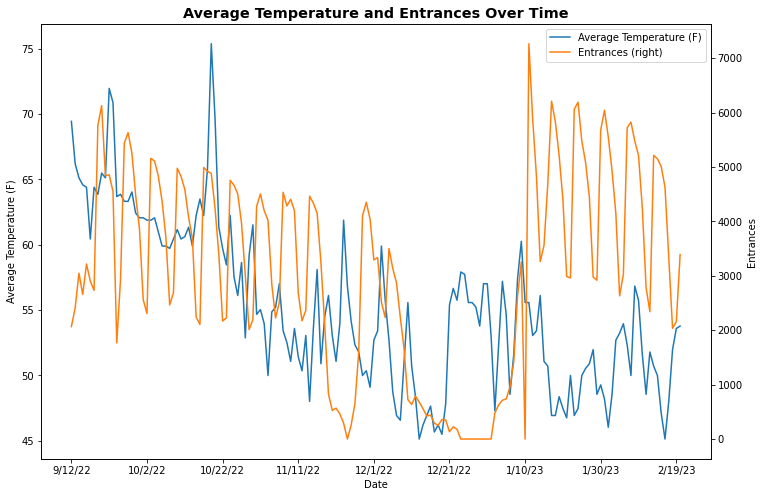

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

merged_df.plot(x = 'Date', y = 'Average Temperature (F)', ax = ax) 
merged_df.plot(x = 'Date', y = 'Entrances', ax = ax, secondary_y = True) 
plt.title("Average Temperature and Entrances Over Time", fontsize = 'x-large', fontweight = 'bold')
ax.set_ylabel('Average Temperature (F)')
ax.right_ax.set_ylabel('Entrances')

First, we created a time series plot with the average temperature in blue and the number of individuals who entered the Cal Poly Rec Center in orange. This graph shows no obvious trend, the peaks are mostly on Mondays and non peaks are mostly on the weekends. The trends for the entrances are pretty much the same on a weekly basis and it springs back up after the holidays, more specifically, after the New Years. However, we can see that the average temperature doesn’t seem to affect the number of entrances, so there is essentially no correlation between the average temperature and the number of individuals who entered the Cal Poly Rec Center. 

### **Scatterplots**

**Average Temperature vs Entrance for All the Data**

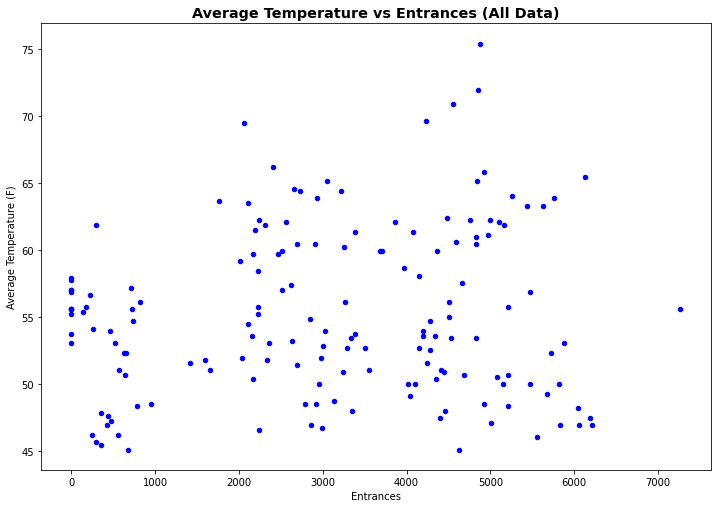

In [ ]:
# with outliers
fig, ax = plt.subplots(figsize=(12, 8))
ax1 = merged_df.plot.scatter(x='Entrances', y='Average Temperature (F)', c='Blue', ax = ax)
plt.title("Average Temperature vs Entrances (All Data)", fontsize = 'x-large', fontweight = 'bold' )
plt.subplots_adjust(top = 0.90)
plt.show()

**Average Temperature vs Entrance Accounting for Holidays**

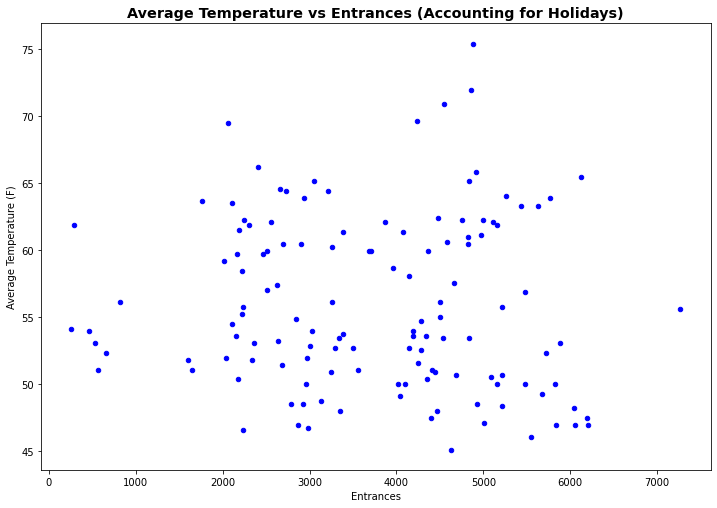

In [ ]:
# without outliers
fig, ax = plt.subplots(figsize=(12, 8))
ax1 = merged_df2.plot.scatter(x='Entrances', y='Average Temperature (F)', c='Blue', ax = ax)
plt.title("Average Temperature vs Entrances (Accounting for Holidays)", fontsize = 'x-large', fontweight = 'bold' )
plt.subplots_adjust(top = 0.90)
plt.show()

**Average Temperature vs Entrance Accounting for Holidays and Weekends**

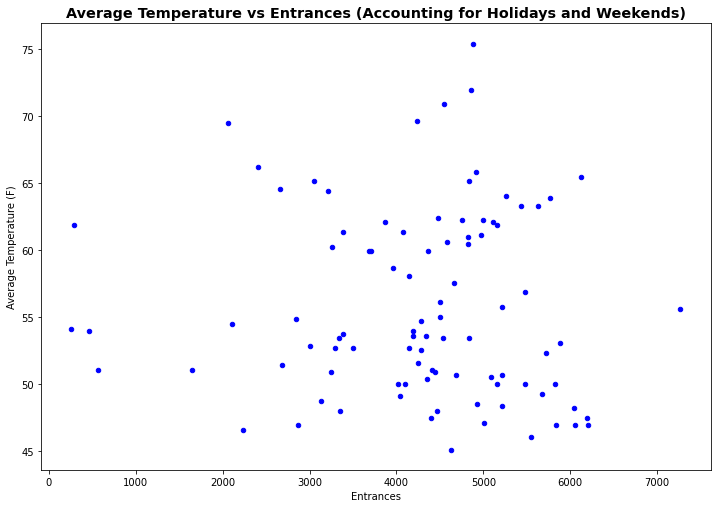

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax1 = merged_df3.plot.scatter(x='Entrances', y='Average Temperature (F)', c='Blue', ax = ax)
plt.title("Average Temperature vs Entrances (Accounting for Holidays and Weekends)", fontsize = 'x-large', fontweight = 'bold' )
plt.subplots_adjust(top = 0.90)
plt.show()

We created three scatterplots: one with all the data, and one that accounts for the holidays, and one that accounts for holidays and weekends, to understand the relationship between the average temperature and the number of individuals who entered the Cal Poly Rec Center. These scatterplots reveal that the points are scattered randomly, indicating that there is no relationship and no correlation between the average temperature in Fahrenheit and the number of individuals who entered the Cal Poly Rec Center.

## **Statistical Analysis**

To further support our analysis, we conducted a Pearson's correlation test to measure the statistical relationship and association between the average temperature in Fahrenheit and the number of individuals who entered the Cal Poly Rec Center. 

### **Pearsons Correlation with All the Data**

In [ ]:
# Convert dataframe into series
Entrances = merged_df['Entrances']
Temp = merged_df['Average Temperature (F)']
 
# Apply the pearsonr()
corr, _ = pearsonr(Entrances, Temp)
print('Pearsons correlation: %.3f' % corr)
 

Pearsons correlation: 0.113


First, we computed the test without removing any specific dates, resulting in a correlation value of 0.113. This indicates that there is a weak positive association between the average temperature in Fahrenheit and the number of individuals who entered the Cal Poly Rec Center.  However this value is fairly close to 0, indicating that it is barely a positive association and if anything, no correlation. However, this fails to account for academic holidays, including Thanksgiving and Winter break, and when the rec center was closed. Thus, this would not be an accurate representation since the outliers of low or zero entrance data would skew our results. 

### **Pearsons Correlation Accounting for Academic Holidays**

In [ ]:
# Convert dataframe into series
Entrances2 = merged_df2['Entrances']
Temp2 = merged_df2['Average Temperature (F)']
 
# Apply the pearsonr()
corr, _ = pearsonr(Entrances2, Temp2)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.060


Thus, we repeated the test and removed the holidays and breaks. This was to take into account the days the students are not on campus due school not being in session. The result was a  correlation value of -0.008, which indicates an extremely weak negative association and if anything, it can be interpreted as no correlation. 

### **Pearsons Correlation Accounting for Academic Holidays and Weekends**

In [ ]:
# Convert dataframe into series
Entrances3 = merged_df3['Entrances']
Temp3 = merged_df3['Average Temperature (F)']
 
# Apply the pearsonr()
corr, _ = pearsonr(Entrances3, Temp3)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.053



We repeated the test a third time to remove holidays as well as weekends to account for the lower population of students who enter on non-school days. The result was a correlation value of -0.053, which also indicates essentially no correlation. 

All of these correlation values are consistent with what we viewed in the scatterplots. Based on the scatterplots and the Pearson's correlation test, we can conclude that a decrease in temperature is not correlated with an increase in the amount of people who use the Cal Poly Rec Center. 



## **Conclusion**

In conclusion, our analysis fails to support our hypothesis and concludes that a decrease in temperature is not correlated with an increase in the amount of people who use the Cal Poly Rec Center. Despite the more extreme weather this year, the temperature usually is steady in San Luis Obispo, with the range of temperature in between 41°F to 78°F. Therefore, weather is most likely not a factor in the amount of people who use the Cal Poly Rec Center. 

To expand our analysis, we could examine other factors besides temperature, such as precipitation. We could also conduct the analysis utilizing smaller time intervals, such as hours, as opposed to days, to obtain a more granular level of evaluations. 

